In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# import sys
# sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
# from utils import 

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)


df_eddies = pd.read_pickle(f'/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
sample_eddies = [24, 85, 1029, 326, 1978, 474, 2741, 971, 249]


In [4]:
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.271431,89.867643
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.198452,93.272349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,11.034884,335.231553
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,11.775489,326.922187
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [32]:
x1, x2 = 470, 560
y1, y2 = 1040, 1140
df_knoll = df_eddies[(df_eddies.xc >= x1) & (df_eddies.xc <= x2) 
                     & (df_eddies.yc >= y1) & (df_eddies.yc <= y2)]


(np.float64(0.0),
 np.float64(988.1356688684336),
 np.float64(0.0),
 np.float64(1561.702894718129))

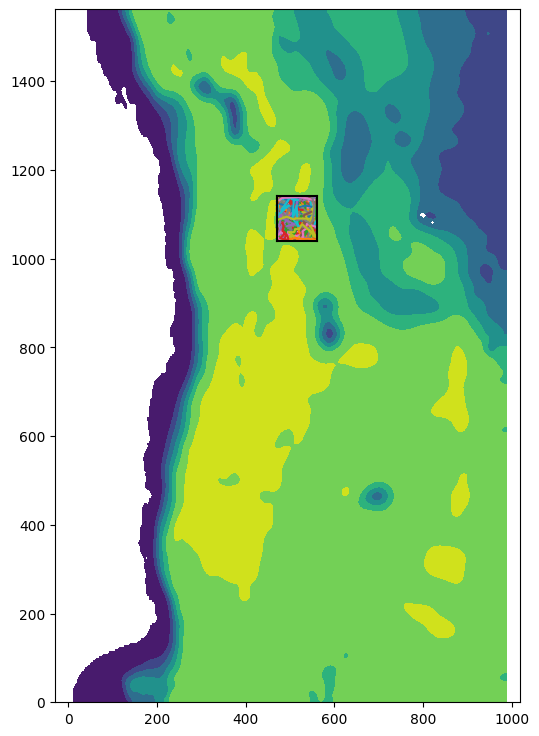

In [33]:
plt.figure(figsize=(6,9))
plt.contourf(X_grid, Y_grid, np.where(mask_rho, h, np.nan))

for eddy in df_knoll.Eddy.unique():
    df = df_knoll[df_knoll.Eddy==eddy]
    plt.plot(df.xc, df.yc)

plt.plot([x1, x2], [y1, y1], color='k')
plt.plot([x1, x2], [y2, y2], color='k')
plt.plot([x1, x1], [y1, y2], color='k')
plt.plot([x2, x2], [y1, y2], color='k')
plt.axis('equal')


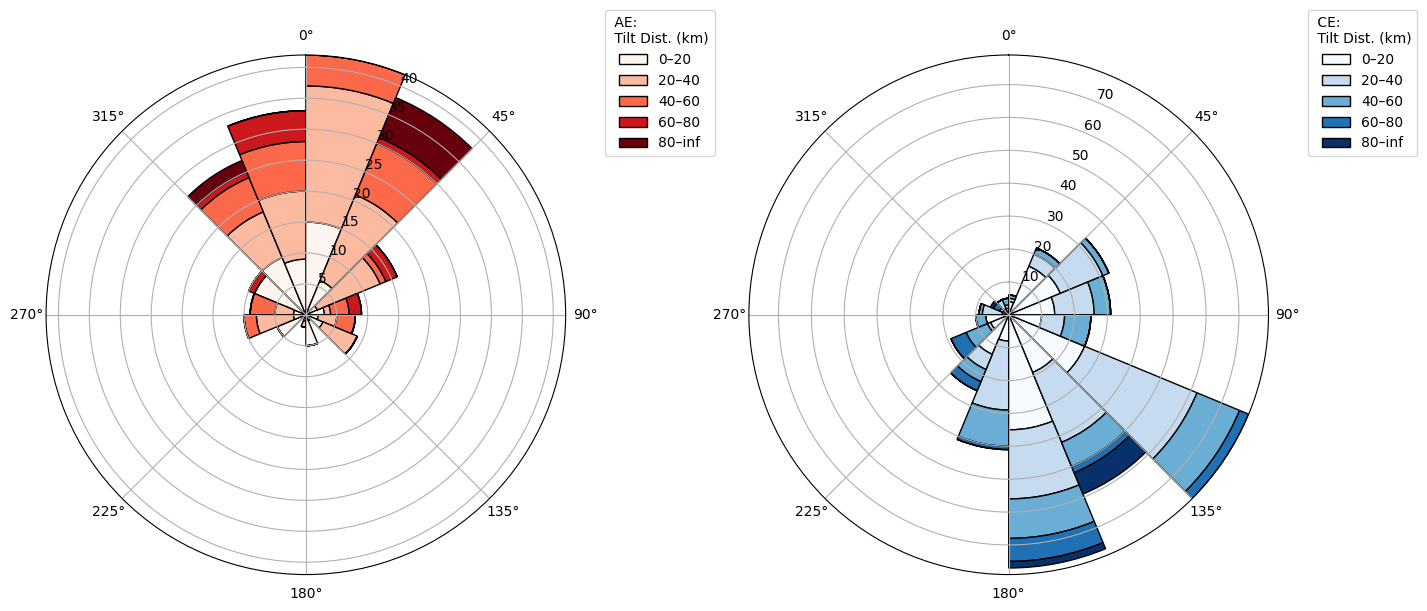

In [34]:
# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 20, 40, 60, 80, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

df_AE = df_knoll[df_knoll.Cyc=='AE'].copy()
df_CE = df_knoll[df_knoll.Cyc=='CE'].copy()

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.TiltDir
    magnitudes = df.TiltDis

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

# One legend for both
plt.show()

In [42]:
x_mean = np.mean([x1, x2])
y_mean = np.mean([y1, y2])


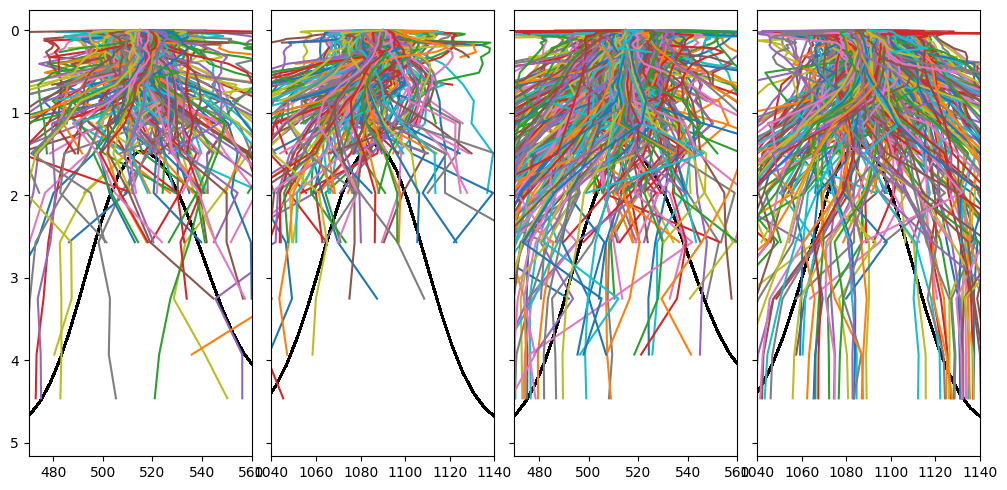

In [51]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(10, 5))
for k in range(len(df_knoll)):
    data = df_knoll.iloc[k]
    df = dic_eddies_vert[f'Eddy{data.Eddy}'][f'Day{data.Day}']
    if len(df):
        if data.Cyc == 'AE':
            axs[0].plot(df.x-df.iloc[0].x + x_mean, -df.Depth/1000)
            jc = np.where(np.abs(y_mean-y_grid)==np.min(np.abs(y_mean-y_grid)))[0][0]
            axs[0].plot(x_grid, h[:, jc]/1000, 'k', zorder=1)
                
            axs[1].plot(df.y-df.iloc[0].y + y_mean, -df.Depth/1000)
            ic = np.where(np.abs(x_mean-x_grid)==np.min(np.abs(x_mean-x_grid)))[0][0]
            axs[1].plot(y_grid, h[ic, :]/1000, 'k', zorder=1)
        else:
            axs[2].plot(df.x-df.iloc[0].x + x_mean, -df.Depth/1000)
            jc = np.where(np.abs(y_mean-y_grid)==np.min(np.abs(y_mean-y_grid)))[0][0]
            axs[2].plot(x_grid, h[:, jc]/1000, 'k', zorder=1)
            axs[3].plot(df.y-df.iloc[0].y + y_mean, -df.Depth/1000)
            ic = np.where(np.abs(x_mean-x_grid)==np.min(np.abs(x_mean-x_grid)))[0][0]
            axs[3].plot(y_grid, h[ic, :]/1000, 'k', zorder=1)
axs[0].set_xlim(x1, x2)
axs[1].set_xlim(y1, y2)
axs[2].set_xlim(x1, x2)
axs[3].set_xlim(y1, y2)
            
axs[0].invert_yaxis()
plt.tight_layout()


### Knoll 2 

In [25]:
x1, x2 = 530, 640
y1, y2 = 780, 930
df_knoll = df_eddies[(df_eddies.xc >= x1) & (df_eddies.xc <= x2) 
                     & (df_eddies.yc >= y1) & (df_eddies.yc <= y2)]


(np.float64(0.0),
 np.float64(988.1356688684336),
 np.float64(0.0),
 np.float64(1561.702894718129))

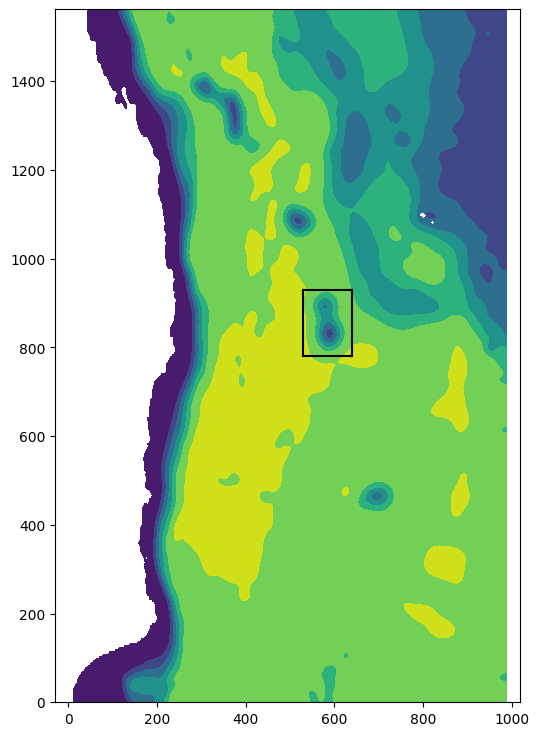

In [27]:
plt.figure(figsize=(6,9))
plt.contourf(X_grid, Y_grid, np.where(mask_rho, h, np.nan))

# for eddy in df_knoll.Eddy.unique():
#     df = df_knoll[df_knoll.Eddy==eddy]
#     plt.plot(df.xc, df.yc)

plt.plot([x1, x2], [y1, y1], color='k')
plt.plot([x1, x2], [y2, y2], color='k')
plt.plot([x1, x1], [y1, y2], color='k')
plt.plot([x2, x2], [y1, y2], color='k')
plt.axis('equal')

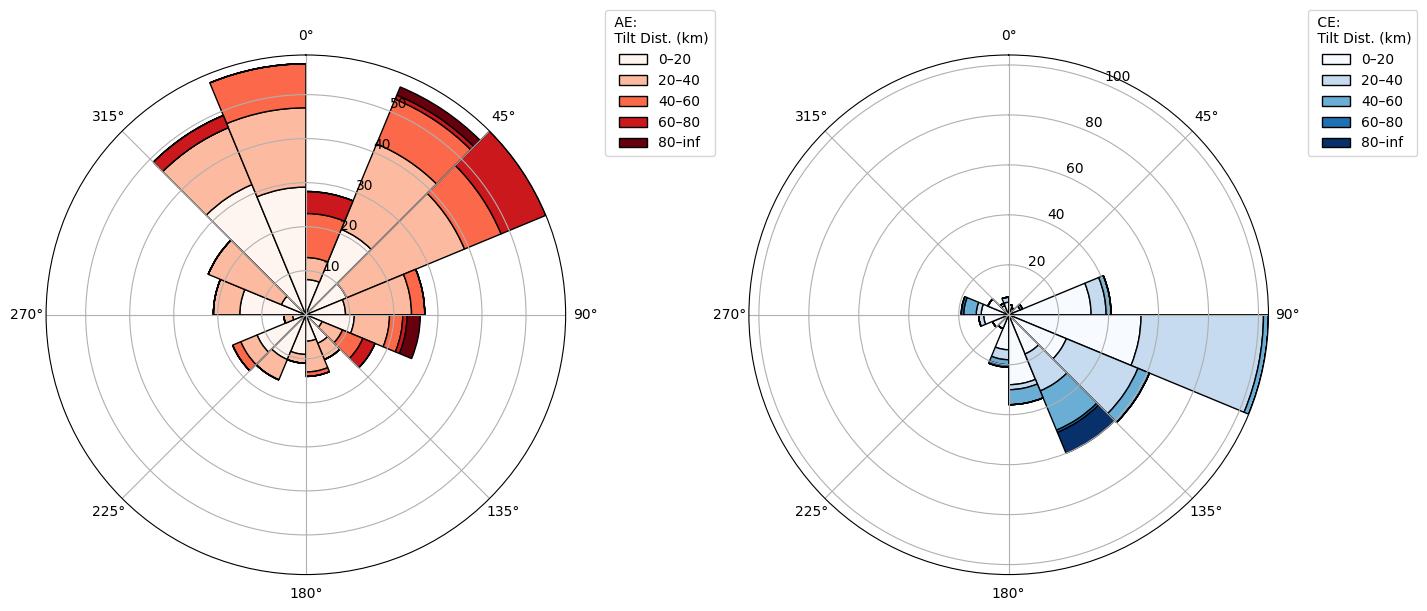

In [28]:
# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 20, 40, 60, 80, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

df_AE = df_knoll[df_knoll.Cyc=='AE'].copy()
df_CE = df_knoll[df_knoll.Cyc=='CE'].copy()

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.TiltDir
    magnitudes = df.TiltDis

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

# One legend for both
plt.show()
